## Data correction

This notebook helps preparing data obtained from pyridine adsorption IR measurements for further evaluation. The data is extracted from the measurement files, corrected, truncated and saved to new csv files.
The baseline correction is done with the measurement data of the unloaded sample ("_hydrated_"). As only the ring breathing vibrations in the range of 1400 cm$^{-1}$ < $\nu$ < 1600 cm$^{-1}$ are of interest, the data is truncated accordingly.

***

First of all, import all needed packages.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import os
import pandas as pd
from pathlib import Path
import re
from scipy.signal import find_peaks, peak_widths
from scipy.optimize import curve_fit
import tempfile
from typing import List, Optional, Union

from python.data_prep import IRDataHandler
from python.gaussian_fit import GaussianFit

print("All done.")

All done.


---
In your current working directory (`cwd`), specify the `folder` containing the data which are to be processed. The list of available files gives an overview over all samples in this specific folder.

In [2]:
folder = "TO_P123-0zu1"
cwd = Path.cwd()
path_to_directory = cwd / folder

In [3]:
data_handling = IRDataHandler(path_to_directory=path_to_directory, folder = folder, decimal=",")
data_handling.available_files()

{0: 'TO_P123-0zu1_300min-450C',
 1: 'TO_P123-0zu1_360min-450C_30min-4mbar-Pyr-RT_15min-300C-Pyr-des',
 2: 'TO_P123-0zu1_360min-450C_30min-4mbar-Pyr-RT_15min-350C-Pyr-des',
 3: 'TO_P123-0zu1_360min-450C_30min-4mbar-Pyr-RT_15min-400C-Pyr-des',
 4: 'TO_P123-0zu1_360min-450C_30min-4mbar-Pyr-RT_15min-450C-Pyr-des',
 5: 'TO_P123-0zu1_360min-450C_30min-4mbar-Pyr-RT_60min-150C-Pyr-des',
 6: 'TO_P123-0zu1_360min-450C_30min-4mbar-Pyr-RT_60min-200C-Pyr-des',
 7: 'TO_P123-0zu1_360min-450C_30min-4mbar-Pyr-RT_60min-250C-Pyr-des'}

---
You can plot all measurement data into one figure for both comparison and publication.
The legend can be extracted from the respective characters in the file name. `val1` gives the first chracter, `val2` the last.

Adding measurement 300 °C to figure.
Adding measurement 350 °C to figure.
Adding measurement 400 °C to figure.
Adding measurement 450 °C to figure.
Adding measurement 150 °C to figure.
Adding measurement 200 °C to figure.
Adding measurement 250 °C to figure.


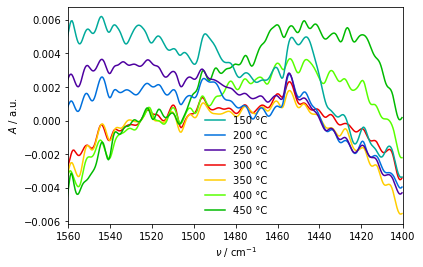

In [4]:
data_handling.get_plot(val1=50, val2=53)

If the plots are satisfactory, you can save your corrected data to new csv files with the following command.

In [5]:
data_handling.save_data_to_csv()

IndexError: list index out of range

***

## Gaussian Fittiing

This notebook can fit two or three peaks in your respective Pyridine-adsorption IR spectra with a Gaussian. With the fitting parameters obtained from the fits, the number of active sites corresponding to Bronsted and/or Lewis sites can be calculated from

$N = \frac{S_{area} \cdot A_{peak}}{m_{sample} \cdot \varepsilon}$

With the sample area $S_{area}$, or area of the sample wafer, the sample mass $m_{sample}$, the absorption coeffiecient $\varepsilon$ of the investigated material and the peak area $A_{peak}$ which is obtained from the fitting parameters.

The calculated results can be saven to a TXT file.

Specify the folder `corr` which holds the corrected data which is to be fitted. 

In [ ]:
corr = "TO_P123-0zu1/corr"
threshold = 0.1
fit = GaussianFit(cwd / corr, threshold = threshold)
fit.available_files()

From the list above, choose a file by its index, which you would like to fit. The control plot shows, if all peaks that should be fitted are found. If peaks are missing or too many peaks are found by the algorithm, adust the threshold value accordingly. Define a `name` which will be the file name of the saved plot. To control if all important peaks are found, check the control plot:

In [ ]:
name = "TO_P123-0zu1_250C"
fit.extract_data(7)
fit.get_control_plot()

---
Carry out the Gaussian fit. Choose the correct fit function according to the number of peaks found in the previously carried out control plot.

a) Two peaks: If only two peaks are found by the algorithm, run the following cell to fit both of them. The number of active sites is then calculated orm the two peaks, the difference equals the Bronsted sites.

In [ ]:
fit.get_gaussian2_plot(name=name)

b) Three peaks:
If three peaks are found by the algorithm, you can fit them with the following cell. WIth this, the number of active sites is calculated from each peak.

In [ ]:
fit.get_gaussian3_plot(name=name)

---
Finally, with the data obtained from the Gaussians, calculate the number of active sites (in $mmol \cdot g^{-1}$) by providing the `sample_mass` in $g$ and the `abs_coeff` (absorption coefficent) in $cm \cdot mmol^{-1}$.

In [ ]:
peaks = 3
sample_mass = 0.0620
abs_coeff = (2.22 * 1000)
sample_area = (1.950 * 0.967)
N = fit.calc_n_sites(sample_area = sample_area, sample_mass=sample_mass, abs_coeff=abs_coeff, peaks=peaks)

b = N[0]-N[1]
if peaks == 3:
    N.append((N[0]+N[2]))
    number_of_sites = {
        "Lewis": float(f"{N[0]:.5f}"),
        "mixed": float(f"{N[1]:.5f}"),
        "Bronsted": float(f"{N[2]:.5f}")
    }
else:
    N.append(N[0]-b)
    number_of_sites = {
        "Lewis": float(f"{N[0]:.5f}"),
        "mixed": float(f"{N[1]:.5f}"),
        "Bronsted": float(f"{b:.5f}")
    }
    N.insert(2,b)
    N.append("*")
number_of_sites

In [ ]:
with open ((folder + ".txt"), "w") as file:
    file.writelines("name lewis mixed bronsted sum \n")

In [ ]:
with open((folder + ".txt"), "a") as file:
    file.writelines(name + str(N) + "\n")
    file.close()

In [ ]:
reader = open((folder + ".txt"), "r")
reader.readlines()